MemCtrl - Notebook 1: Dataset Processing & Construction
================================================

This notebook:
1. Loads LMSYS-Chat-1M and WildChat datasets
2. Labels prompts using hybrid pattern+LLM approach
3. Cleans and balances the dataset
4. Validates quality at every step
5. Saves labeled dataset for training

Author: Kamala
Last Updated: Dec 2024

In [1]:
from datasets import load_dataset

In [2]:
print("="*80)
print("MEMCTRL - DATASET PROCESSING (HYBRID APPROACH)")
print("="*80)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install dependencies
print("\nInstalling dependencies...")
!pip install -q transformers datasets pandas numpy scikit-learn matplotlib seaborn tqdm

# Verify installations
import sys
print("\nChecking installations:")
try:
    import torch
    import pandas as pd
    import numpy as np
    from datasets import load_dataset
    from sklearn.model_selection import train_test_split
    import json
    from pathlib import Path
    from typing import Dict, List, Tuple
    from collections import Counter
    from tqdm import tqdm
    import matplotlib.pyplot as plt
    import seaborn as sns
    import datetime
    import re
    print("  [PASS] All packages imported successfully")
except ImportError as e:
    print(f"  [FAIL] Import error: {e}")
    sys.exit(1)

# Check GPU (not required but nice to have)
if torch.cuda.is_available():
    print(f"\nGPU Available: {torch.cuda.get_device_name(0)}")
else:
    print("\nRunning on CPU")

print("\n" + "="*80)
print("READY TO PROCESS DATASETS")
print("="*80)

MEMCTRL - DATASET PROCESSING (HYBRID APPROACH)
Mounted at /content/drive

Installing dependencies...

Checking installations:
  [PASS] All packages imported successfully

Running on CPU

READY TO PROCESS DATASETS


In [3]:
# CONFIGURE THESE PATHS
CONFIG = {
    # HuggingFace dataset names
    'lmsys_hf_dataset': 'lmsys/lmsys-chat-1m',
    'wildchat_hf_dataset': 'allenai/WildChat',
    'clinc150_hf_dataset': 'clinc/clinc_oos',

    # Where to save downloaded datasets (will be created)
    'datasets_dir': '/content/drive/MyDrive/memctrl_datasets',

    # Output directory for processed data
    'output_dir': '/content/drive/MyDrive/memctrl_data',

    # Sampling (set to None to use all data)
    'max_samples_per_source': 50000,  # 50k from each dataset

    # Whether to download datasets (set False if already downloaded)
    'download_datasets': True,

    # Balancing
    'balance_strategy': 'undersample',
    'max_samples_per_class': 10000,
    'min_samples_per_class': 100,  # Lower threshold since we have more data
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Create directories
datasets_dir = Path(CONFIG['datasets_dir'])
datasets_dir.mkdir(parents=True, exist_ok=True)

output_dir = Path(CONFIG['output_dir'])
output_dir.mkdir(parents=True, exist_ok=True)

print(f"\nDatasets directory: {datasets_dir}")
print(f"Output directory: {output_dir}")

Configuration:
  lmsys_hf_dataset: lmsys/lmsys-chat-1m
  wildchat_hf_dataset: allenai/WildChat
  clinc150_hf_dataset: clinc/clinc_oos
  datasets_dir: /content/drive/MyDrive/memctrl_datasets
  output_dir: /content/drive/MyDrive/memctrl_data
  max_samples_per_source: 50000
  download_datasets: True
  balance_strategy: undersample
  max_samples_per_class: 10000
  min_samples_per_class: 100

Datasets directory: /content/drive/MyDrive/memctrl_datasets
Output directory: /content/drive/MyDrive/memctrl_data


In [4]:
from huggingface_hub import login
login()

In [5]:
print("\n" + "="*80)
print("DOWNLOADING DATASETS FROM HUGGINGFACE")
print("="*80)

import datetime

def serialize_item(item):
    """
    Convert HuggingFace dataset item to JSON-serializable dict
    Handles datetime objects and other non-serializable types
    """
    serialized = {}
    for key, value in item.items():
        if isinstance(value, datetime.datetime):
            serialized[key] = value.isoformat()
        elif isinstance(value, datetime.date):
            serialized[key] = value.isoformat()
        elif isinstance(value, (list, tuple)):
            serialized[key] = [
                v.isoformat() if isinstance(v, (datetime.datetime, datetime.date)) else v
                for v in value
            ]
        elif isinstance(value, dict):
            serialized[key] = serialize_item(value)
        else:
            serialized[key] = value

    return serialized

def download_lmsys(output_path: Path, max_samples: int = None):
    """Download LMSYS-Chat-1M from HuggingFace"""
    print(f"\nDownloading LMSYS-Chat-1M from HuggingFace...")
    print("This may take 10-20 minutes for the full dataset.")

    try:
        dataset = load_dataset(
            CONFIG['lmsys_hf_dataset'],
            split='train',
            streaming=True
        )
        print(f"[PASS] Dataset loaded in streaming mode")

        print(f"Saving to {output_path}...")
        count = 0

        with open(output_path, 'w', encoding='utf-8') as f:
            for item in tqdm(dataset, desc="Writing LMSYS", total=max_samples):
                if max_samples and count >= max_samples:
                    break

                serialized = serialize_item(item)
                json.dump(serialized, f, ensure_ascii=False)
                f.write('\n')
                count += 1

        size_mb = output_path.stat().st_size / (1024 * 1024)
        print(f"[PASS] Saved {count} conversations to {output_path} ({size_mb:.1f} MB)")

        return True

    except Exception as e:
        print(f"[FAIL] Error downloading LMSYS: {e}")
        import traceback
        traceback.print_exc()
        return False

def download_wildchat(output_path: Path, max_samples: int = None):
    """Download WildChat from HuggingFace"""
    print(f"\nDownloading WildChat from HuggingFace...")
    print("This may take 10-20 minutes for the full dataset.")

    try:
        dataset = load_dataset(
            CONFIG['wildchat_hf_dataset'],
            split='train',
            streaming=True
        )
        print(f"[PASS] Dataset loaded in streaming mode")

        print(f"Saving to {output_path}...")
        count = 0

        with open(output_path, 'w', encoding='utf-8') as f:
            for item in tqdm(dataset, desc="Writing WildChat", total=max_samples):
                if max_samples and count >= max_samples:
                    break

                serialized = serialize_item(item)
                json.dump(serialized, f, ensure_ascii=False)
                f.write('\n')
                count += 1

        size_mb = output_path.stat().st_size / (1024 * 1024)
        print(f"[PASS] Saved {count} conversations to {output_path} ({size_mb:.1f} MB)")

        return True

    except Exception as e:
        print(f"[FAIL] Error downloading WildChat: {e}")
        import traceback
        traceback.print_exc()
        return False

# Download datasets if needed
lmsys_path = datasets_dir / 'lmsys-chat-1m.jsonl'
wildchat_path = datasets_dir / 'wildchat.jsonl'

if CONFIG['download_datasets']:
    print("\nDownload mode: ENABLED")
    print("Note: This will download and save datasets to Google Drive.")
    print("Datasets are large - ensure you have sufficient Drive storage.")

    # Download LMSYS
    if not lmsys_path.exists():
        success = download_lmsys(lmsys_path, CONFIG['max_samples_per_source'])
        if not success:
            print("\nWARNING: LMSYS download failed. Continuing without it.")
    else:
        size_mb = lmsys_path.stat().st_size / (1024 * 1024)
        print(f"\n[SKIP] LMSYS already exists at {lmsys_path} ({size_mb:.1f} MB)")

    # Download WildChat
    if not wildchat_path.exists():
        success = download_wildchat(wildchat_path, CONFIG['max_samples_per_source'])
        if not success:
            print("\nWARNING: WildChat download failed. Continuing without it.")
    else:
        size_mb = wildchat_path.stat().st_size / (1024 * 1024)
        print(f"\n[SKIP] WildChat already exists at {wildchat_path} ({size_mb:.1f} MB)")
else:
    print("\nDownload mode: DISABLED")
    print("Expecting datasets to already exist:")

    for name, path in [('LMSYS', lmsys_path), ('WildChat', wildchat_path)]:
        if path.exists():
            size_mb = path.stat().st_size / (1024 * 1024)
            print(f"  [PASS] {name}: {size_mb:.1f} MB")
        else:
            print(f"  [FAIL] {name}: NOT FOUND at {path}")

# Update CONFIG with actual paths
CONFIG['lmsys_path'] = str(lmsys_path) if lmsys_path.exists() else None
CONFIG['wildchat_path'] = str(wildchat_path) if wildchat_path.exists() else None

print("\n" + "="*80)
print("DATASET DOWNLOAD COMPLETE")
print("="*80)


DOWNLOADING DATASETS FROM HUGGINGFACE

Download mode: ENABLED
Note: This will download and save datasets to Google Drive.
Datasets are large - ensure you have sufficient Drive storage.

[SKIP] LMSYS already exists at /content/drive/MyDrive/memctrl_datasets/lmsys-chat-1m.jsonl (244.0 MB)

[SKIP] WildChat already exists at /content/drive/MyDrive/memctrl_datasets/wildchat.jsonl (566.3 MB)

DATASET DOWNLOAD COMPLETE


In [6]:
class TaskTaxonomy:
    """50-class taxonomy for MemCtrl"""

    TAXONOMY = {
        "Health & Well-Being": [
            "Personal Medical Disclosure",
            "Medical Advice Request",
            "Third-Person Medical Information",
            "Mental Health Disclosure",
            "Medication & Treatment Inquiry",
            "Symptom Description",
            "Fitness & Physical Health",
            "Nutrition & Diet Discussion"
        ],
        "Education & Knowledge": [
            "Academic Doubt",
            "Homework Help",
            "Research Discussion",
            "Concept Explanation",
            "Exam Preparation",
            "Study & Learning Strategy",
            "Factual Knowledge Query",
            "Geography Query",
            "Historical Information",
            "Scientific Explanation"
        ],
        "Technology & Engineering": [
            "Programming Help",
            "Debugging & Error Diagnosis",
            "System Design",
            "Software Architecture",
            "AI / ML Discussion",
            "Data Science Discussion",
            "Cybersecurity Discussion",
            "Hardware & Devices",
            "Technology Comparison"
        ],
        "Career & Professional": [
            "Career Advice",
            "Interview Preparation",
            "Resume / CV Help",
            "Job Search Strategy",
            "Workplace Communication",
            "Professional Skill Development"
        ],
        "Casual & Social": [
            "General Small Talk",
            "Weather Query",
            "Personal Preference",
            "Opinion Sharing",
            "Storytelling / Anecdote",
            "Relationship & Social Advice"
        ],
        "Legal, Financial & Governance": [
            "Legal Information",
            "Financial Information",
            "Taxes & Accounting",
            "Insurance & Benefits",
            "Government & Civic Information"
        ],
        "Meta, Memory & Control": [
            "Long-Term User Constraint",
            "Short-Term Task Context",
            "Preference Clarification",
            "Instruction Following",
            "Meta-Question About the System",
            "Feedback / Correction"
        ]
    }

    def __init__(self):
        self.categories = list(self.TAXONOMY.keys())
        self.all_classes = self._get_all_classes()
        self.class_to_category = self._build_mapping()

    def _get_all_classes(self):
        classes = []
        for cat_classes in self.TAXONOMY.values():
            classes.extend(cat_classes)
        return classes

    def _build_mapping(self):
        mapping = {}
        for category, classes in self.TAXONOMY.items():
            for cls in classes:
                mapping[cls] = category
        return mapping

    def validate(self):
        """Validate taxonomy structure"""
        print("Validating taxonomy...")

        all_classes_list = []
        for classes in self.TAXONOMY.values():
            all_classes_list.extend(classes)

        duplicates = [c for c, count in Counter(all_classes_list).items() if count > 1]

        if duplicates:
            print(f"  [FAIL] Found duplicate classes: {duplicates}")
            return False

        print(f"  [PASS] {len(self.categories)} categories")
        print(f"  [PASS] {len(self.all_classes)} unique classes")
        print(f"  [PASS] No duplicates found")
        return True

# Initialize and validate taxonomy
taxonomy = TaskTaxonomy()
assert taxonomy.validate(), "Taxonomy validation failed!"

# Save taxonomy
with open(output_dir / 'taxonomy.json', 'w') as f:
    json.dump(taxonomy.TAXONOMY, f, indent=2)
print(f"\n[PASS] Taxonomy saved to {output_dir / 'taxonomy.json'}")

Validating taxonomy...
  [PASS] 7 categories
  [PASS] 50 unique classes
  [PASS] No duplicates found

[PASS] Taxonomy saved to /content/drive/MyDrive/memctrl_data/taxonomy.json


In [7]:
#===============================================================================
# CELL 5: EXPANDED Pattern-Based Labeler
#===============================================================================

class ExpandedPatternLabeler:
    """Comprehensive pattern-based labeling covering 30+ classes"""

    def __init__(self, taxonomy):
        self.taxonomy = taxonomy
        self.patterns = self._define_patterns()
        self.stats = {'matched': 0, 'unmatched': 0}

    def _define_patterns(self):
        """Expanded high-confidence regex patterns for 30 classes"""
        return {
            # Technology & Engineering (9 classes)
            "Programming Help": [
                r"\b(write|create|make|build|develop)\s+.*\b(code|function|script|program|app)\b",
                r"\bhow\s+(do\s+i|to|can\s+i)\s+.*\b(code|program|implement)\b",
                r"\b(python|javascript|java|c\+\+|ruby|go|rust)\s+(function|class|script)\b",
            ],
            "Debugging & Error Diagnosis": [
                r"\b(error|bug|exception|traceback|stacktrace)\b",
                r"\b(debug|fix|solve)\s+.*\b(error|bug|issue)\b",
                r"\b(doesn'?t|does\s+not|isn'?t)\s+work",
                r"\b(syntax\s+error|runtime\s+error|type\s+error)\b",
                r"\bgetting\s+.*\berror\b",
            ],
            "AI / ML Discussion": [
                r"\b(machine\s+learning|deep\s+learning|neural\s+network|transformer)\b",
                r"\b(pytorch|tensorflow|keras|scikit-learn)\b",
                r"\b(train|training)\s+.*\bmodel\b",
                r"\b(nlp|computer\s+vision|reinforcement\s+learning)\b",
            ],
            "System Design": [
                r"\b(system\s+design|architecture|scalability|microservices)\b",
                r"\bdesign\s+.*\b(system|application|service)\b",
            ],
            "Data Science Discussion": [
                r"\b(data\s+science|data\s+analysis|pandas|numpy)\b",
                r"\banalyze.*\bdata\b",
                r"\b(regression|classification|clustering)\b",
            ],
            "Technology Comparison": [
                r"\b(comparison|compare|versus|vs\.?|better\s+than)\b.*\b(framework|library|language|database)\b",
                r"\bshould\s+i\s+use.*\bor\b",
            ],

            # Health & Well-Being (8 classes)
            "Medical Advice Request": [
                r"\bshould\s+i\s+(take|see|get|go\s+to)\b",
                r"\bis\s+it\s+(safe|normal|okay)\s+to\b",
                r"\bdo\s+i\s+need\s+(doctor|hospital|medication)\b",
            ],
            "Symptom Description": [
                r"\bi\s+(have|am\s+experiencing)\s+.*\b(pain|ache|fever|cough)\b",
                r"\bmy.*\b(hurts|aches|painful)\b",
                r"\bi\s+feel\s+(sick|ill|unwell)\b",
            ],
            "Medication & Treatment Inquiry": [
                r"\b(medication|medicine|prescription|drug|pill|treatment)\b",
                r"\b(dosage|side\s+effects|interactions)\b",
            ],
            "Mental Health Disclosure": [
                r"\b(depressed|depression|anxiety|anxious|panic\s+attack)\b",
                r"\bi\s+(feel|am)\s+(depressed|anxious|stressed)\b",
                r"\b(therapist|therapy|counseling)\b",
            ],
            "Fitness & Physical Health": [
                r"\b(workout|exercise|fitness|gym|training)\b",
                r"\bhow\s+to\s+(lose\s+weight|gain\s+muscle|get\s+fit)\b",
            ],
            "Nutrition & Diet Discussion": [
                r"\b(diet|nutrition|calories|protein)\b",
                r"\bwhat\s+should\s+i\s+eat\b",
                r"\b(vegan|vegetarian|keto)\b",
            ],

            # Education & Knowledge (10 classes)
            "Homework Help": [
                r"\b(homework|assignment|problem\s+set)\b",
                r"\bdue\s+(tomorrow|today|next\s+week)\b",
                r"\bhelp.*\b(homework|assignment)\b",
            ],
            "Concept Explanation": [
                r"\bexplain.*\b(concept|theory|idea)\b",
                r"\bwhat\s+(is|are|does).*\bmean\b",
                r"\beli5\b",
            ],
            "Scientific Explanation": [
                r"\bhow\s+does.*\bwork\b",
                r"\bwhy\s+(is|are|does)\b",
                r"\b(physics|chemistry|biology|quantum)\b",
            ],
            "Factual Knowledge Query": [
                r"\bwhat\s+(is|are)\s+(the|a)\b",
                r"\bwho\s+(is|was)\b",
                r"\btell\s+me\s+about\b",
            ],
            "Historical Information": [
                r"\b(history|historical|ancient)\b",
                r"\bin\s+\d{3,4}\b",
                r"\b(war|empire|civilization)\b",
            ],
            "Geography Query": [
                r"\bwhere\s+is\b",
                r"\bcapital\s+of\b",
                r"\b(country|city|continent)\b",
            ],

            # Career & Professional (6 classes)
            "Career Advice": [
                r"\bcareer\s+(advice|path|change)\b",
                r"\bshould\s+i\s+switch.*\b(job|career)\b",
            ],
            "Interview Preparation": [
                r"\binterview\b",
                r"\binterview\s+(questions|tips|preparation)\b",
            ],
            "Resume / CV Help": [
                r"\b(resume|cv)\b",
                r"\bhow\s+to\s+write.*\bresume\b",
            ],
            "Workplace Communication": [
                r"\bemail.*\b(work|boss|manager)\b",
                r"\bprofessional\s+email\b",
            ],

            # Casual & Social (6 classes)
            "General Small Talk": [
                r"^(hi|hello|hey)[\s\.,!?]*$",
                r"^how\s+are\s+you[\s\?,!]*$",
                r"^what'?s\s+up[\s\?,!]*$",
            ],
            "Weather Query": [
                r"\bweather\b",
                r"\b(temperature|forecast|rain|snow)\b",
            ],
            "Personal Preference": [
                r"\bwhat\s+(do\s+you|should\s+i)\s+(like|prefer|recommend)\b",
                r"\bfavorite\s+(movie|book|food)\b",
            ],
            "Opinion Sharing": [
                r"\bwhat\s+do\s+you\s+think\s+(about|of)\b",
                r"\bi\s+think\s+that\b",
            ],
            "Relationship & Social Advice": [
                r"\b(relationship|dating|friendship)\b",
                r"\bsocial\s+(skills|anxiety)\b",
            ],

            # Meta, Memory & Control (6 classes)
            "Instruction Following": [
                r"\b(always|never|from\s+now\s+on)\b",
                r"\bmake\s+sure\s+(to|you)\b",
            ],
            "Preference Clarification": [
                r"\bi\s+prefer\s+that\s+you\b",
                r"\bplease\s+(use|don'?t)\b",
            ],
            "Long-Term User Constraint": [
                r"\bfrom\s+now\s+on\b",
                r"\balways\s+(use|format)\b",
            ],

            # Legal, Financial & Governance (5 classes)
            "Legal Information": [
                r"\b(legal|law|lawsuit|attorney|court)\b",
                r"\bis\s+it\s+legal\b",
            ],
            "Financial Information": [
                r"\b(invest|investment|stock|portfolio)\b",
                r"\b(finance|financial|money)\b",
            ],
            "Taxes & Accounting": [
                r"\b(tax|taxes|irs|deduction)\b",
                r"\bfile.*\btax\b",
            ],
        }

    def label(self, prompt):
        """Label single prompt"""
        prompt_lower = prompt.lower().strip()

        for class_name, patterns in self.patterns.items():
            for pattern in patterns:
                if re.search(pattern, prompt_lower):
                    self.stats['matched'] += 1
                    return class_name, 0.95

        self.stats['unmatched'] += 1
        return None, 0.0

    def label_batch(self, prompts):
        """Label batch of prompts"""
        return [self.label(p) for p in prompts]

    def get_stats(self):
        """Get labeling statistics"""
        total = self.stats['matched'] + self.stats['unmatched']
        if total == 0:
            return "No prompts labeled yet"
        match_rate = self.stats['matched'] / total * 100
        return f"Matched: {self.stats['matched']}/{total} ({match_rate:.1f}%)"

# Test expanded labeler
print("\nTesting Expanded Pattern Labeler:")
test_prompts = [
    "How do I write a Python function?",
    "I'm getting an error in my code",
    "What's the weather?",
    "Tell me about machine learning",
    "I have a headache",
    "Explain quantum mechanics",
    "Help me with my interview",
]

labeler = ExpandedPatternLabeler(taxonomy)
for prompt in test_prompts:
    label, conf = labeler.label(prompt)
    status = "[MATCH]" if label else "[MISS]"
    result = label or "NO MATCH"
    print(f"  {status} '{prompt}' -> {result}")

print(f"\nPattern labeler covers {len(labeler.patterns)} classes out of {len(taxonomy.all_classes)}")


Testing Expanded Pattern Labeler:
  [MATCH] 'How do I write a Python function?' -> Programming Help
  [MATCH] 'I'm getting an error in my code' -> Debugging & Error Diagnosis
  [MATCH] 'What's the weather?' -> Weather Query
  [MATCH] 'Tell me about machine learning' -> AI / ML Discussion
  [MISS] 'I have a headache' -> NO MATCH
  [MATCH] 'Explain quantum mechanics' -> Scientific Explanation
  [MATCH] 'Help me with my interview' -> Interview Preparation

Pattern labeler covers 33 classes out of 50


In [8]:
#===============================================================================
# CELL 6: Dataset Loaders (FIXED for LMSYS)
#===============================================================================

class DatasetLoader:
    """Load and validate datasets"""

    @staticmethod
    def load_lmsys(filepath, max_samples=None):
        """Load LMSYS with validation - FIXED"""
        print(f"\nLoading LMSYS from {filepath}...")

        if not Path(filepath).exists():
            print(f"  [FAIL] File not found!")
            return []

        data = []
        errors = 0

        with open(filepath, 'r', encoding='utf-8') as f:
            for i, line in enumerate(tqdm(f, desc="Processing LMSYS")):
                if max_samples and len(data) >= max_samples:
                    break

                line = line.strip()
                if not line:
                    continue

                try:
                    conv = json.loads(line)

                    if not isinstance(conv, dict):
                        continue

                    conversation = conv.get('conversation', [])

                    if not isinstance(conversation, list):
                        continue

                    # Extract first user turn
                    for turn in conversation:
                        if not isinstance(turn, dict):
                            continue

                        if turn.get('role') == 'user':
                            prompt = turn.get('content', '').strip()

                            if prompt and 10 <= len(prompt) <= 2000:
                                # Handle openai_moderation as list or dict
                                toxic = False
                                om = conv.get('openai_moderation')
                                if isinstance(om, list) and len(om) > 0:
                                    toxic = om[0].get('flagged', False)
                                elif isinstance(om, dict):
                                    toxic = om.get('flagged', False)

                                data.append({
                                    'prompt': prompt,
                                    'source': 'lmsys',
                                    'language': conv.get('language', 'en'),
                                    'toxic': toxic
                                })
                            break

                except (json.JSONDecodeError, KeyError, AttributeError, TypeError) as e:
                    errors += 1
                    if errors <= 5:
                        print(f"  [WARN] Line {i}: {str(e)[:100]}")

        print(f"  [PASS] Loaded {len(data)} prompts")
        if errors > 0:
            print(f"  [WARN] {errors} errors encountered")

        return data

    @staticmethod
    def load_wildchat(filepath, max_samples=None):
        """Load WildChat with validation"""
        print(f"\nLoading WildChat from {filepath}...")

        if not Path(filepath).exists():
            print(f"  [FAIL] File not found!")
            return []

        data = []
        errors = 0

        with open(filepath, 'r', encoding='utf-8') as f:
            for i, line in enumerate(tqdm(f, desc="Processing WildChat")):
                if max_samples and len(data) >= max_samples:
                    break

                line = line.strip()
                if not line:
                    continue

                try:
                    conv = json.loads(line)

                    if not isinstance(conv, dict):
                        continue

                    conversation = conv.get('conversation', [])

                    if not isinstance(conversation, list):
                        continue

                    for turn in conversation:
                        if not isinstance(turn, dict):
                            continue

                        if turn.get('role') == 'user':
                            prompt = turn.get('content', '').strip()

                            if prompt and 10 <= len(prompt) <= 2000:
                                data.append({
                                    'prompt': prompt,
                                    'source': 'wildchat',
                                    'language': conv.get('language', 'en'),
                                    'toxic': conv.get('toxic', False)
                                })
                            break

                except (json.JSONDecodeError, KeyError, AttributeError, TypeError) as e:
                    errors += 1
                    if errors <= 5:
                        print(f"  [WARN] Line {i}: {str(e)[:100]}")

        print(f"  [PASS] Loaded {len(data)} prompts")
        if errors > 0:
            print(f"  [WARN] {errors} errors encountered")

        return data

# Load conversational datasets
conversational_data = []

if CONFIG['lmsys_path'] and Path(CONFIG['lmsys_path']).exists():
    lmsys_data = DatasetLoader.load_lmsys(
        CONFIG['lmsys_path'],
        CONFIG['max_samples_per_source']
    )
    conversational_data.extend(lmsys_data)
    print(f"[PASS] LMSYS contributed {len(lmsys_data)} prompts")

if CONFIG['wildchat_path'] and Path(CONFIG['wildchat_path']).exists():
    wildchat_data = DatasetLoader.load_wildchat(
        CONFIG['wildchat_path'],
        CONFIG['max_samples_per_source']
    )
    conversational_data.extend(wildchat_data)
    print(f"[PASS] WildChat contributed {len(wildchat_data)} prompts")

print(f"\n{'='*80}")
print(f"CONVERSATIONAL DATA LOADED: {len(conversational_data)}")
print(f"{'='*80}")


Loading LMSYS from /content/drive/MyDrive/memctrl_datasets/lmsys-chat-1m.jsonl...


Processing LMSYS: 50000it [00:05, 8934.29it/s] 


  [PASS] Loaded 44373 prompts
[PASS] LMSYS contributed 44373 prompts

Loading WildChat from /content/drive/MyDrive/memctrl_datasets/wildchat.jsonl...


Processing WildChat: 50000it [00:16, 2968.53it/s]

  [PASS] Loaded 40492 prompts
[PASS] WildChat contributed 40492 prompts

CONVERSATIONAL DATA LOADED: 84865


In [14]:
#===============================================================================
# CELL 7: Download and Map CLINC150 Dataset (FIXED)
#===============================================================================

print("\n" + "="*80)
print("DOWNLOADING AND MAPPING CLINC150")
print("="*80)

# Download CLINC150
print("\nDownloading CLINC150 dataset...")
clinc_dataset = load_dataset('clinc/clinc_oos', 'plus', split='train')
print(f"[PASS] Downloaded {len(clinc_dataset)} CLINC150 samples")

# Get intent decoder
intent_feature = clinc_dataset.features['intent']

# Define mapping from CLINC150 intents to your taxonomy
CLINC_TO_MEMCTRL = {
    # Weather
    'weather': 'Weather Query',

    # Casual & Social
    'greeting': 'General Small Talk',
    'goodbye': 'General Small Talk',
    'thank_you': 'General Small Talk',
    'affirm': 'General Small Talk',
    'negate': 'General Small Talk',

    # Opinion & Preferences
    'restaurant_reviews': 'Opinion Sharing',
    'restaurant_reservation': 'Personal Preference',
    'restaurant_suggestion': 'Personal Preference',
    'book_hotel': 'Personal Preference',
    'book_flight': 'Personal Preference',

    # Food & Nutrition
    'calories': 'Nutrition & Diet Discussion',
    'nutrition_info': 'Nutrition & Diet Discussion',
    'recipe': 'Nutrition & Diet Discussion',

    # Knowledge queries
    'meaning_of_life': 'Factual Knowledge Query',
    'fun_fact': 'Factual Knowledge Query',
    'what_are_your_hobbies': 'Meta-Question About the System',
    'user_name': 'Meta-Question About the System',

    # Travel
    'travel_suggestion': 'Personal Preference',
    'travel_alert': 'Factual Knowledge Query',
    'travel_notification': 'Factual Knowledge Query',

    # News
    'news': 'Factual Knowledge Query',

    # Geography & Knowledge
    'timezone': 'Geography Query',
    'distance': 'Geography Query',
    'current_location': 'Geography Query',

    # Time management
    'calendar': 'Short-Term Task Context',
    'reminder': 'Short-Term Task Context',
    'todo_list': 'Short-Term Task Context',
    'alarm': 'Short-Term Task Context',
    'timer': 'Short-Term Task Context',
    'schedule_meeting': 'Short-Term Task Context',
    'meeting_schedule': 'Short-Term Task Context',

    # Communication
    'text': 'Workplace Communication',
    'make_call': 'Workplace Communication',

    # Shopping preferences
    'shopping_list': 'Personal Preference',
    'order': 'Personal Preference',
    'order_status': 'Personal Preference',

    # Questions
    'spelling': 'Factual Knowledge Query',
    'definition': 'Concept Explanation',
    'translate': 'Concept Explanation',
}

# Map CLINC150 data with DECODING
print("\nMapping CLINC150 intents to MemCtrl taxonomy...")
clinc_mapped = []

for item in tqdm(clinc_dataset, desc="Mapping CLINC150"):
    # DECODE the integer intent to string name
    intent_id = item['intent']
    intent_name = intent_feature.int2str(intent_id)

    if intent_name in CLINC_TO_MEMCTRL:
        clinc_mapped.append({
            'prompt': item['text'],
            'label': CLINC_TO_MEMCTRL[intent_name],
            'source': 'clinc150',
            'language': 'en',
            'toxic': False,
            'confidence': 1.0,
            'method': 'clinc150_mapped'
        })

print(f"[PASS] Mapped {len(clinc_mapped)} CLINC150 samples")
print(f"Coverage: {len(set([x['label'] for x in clinc_mapped]))} classes from CLINC150")

# Show mapping statistics
print("\nCLINC150 contribution by class:")
clinc_class_counts = Counter([x['label'] for x in clinc_mapped])
for class_name, count in clinc_class_counts.most_common():
    print(f"  {class_name}: {count}")


DOWNLOADING AND MAPPING CLINC150

[PASS] Downloaded 15250 CLINC150 samples

Mapping CLINC150 intents to MemCtrl taxonomy...


Mapping CLINC150: 100%|██████████| 15250/15250 [00:00<00:00, 21593.28it/s]

[PASS] Mapped 3700 CLINC150 samples
Coverage: 11 classes from CLINC150

CLINC150 contribution by class:
  Personal Preference: 800
  Short-Term Task Context: 700
  Factual Knowledge Query: 500
  Geography Query: 300
  Nutrition & Diet Discussion: 300
  General Small Talk: 300
  Concept Explanation: 200
  Meta-Question About the System: 200
  Workplace Communication: 200
  Opinion Sharing: 100
  Weather Query: 100


In [16]:
#===============================================================================
# CELL 8: Label Conversational Data with Patterns
#===============================================================================

print("\n" + "="*80)
print("LABELING CONVERSATIONAL DATA WITH PATTERNS")
print("="*80)

# Convert to DataFrame
conv_df = pd.DataFrame(conversational_data)

# Label using expanded pattern matcher
print(f"\nLabeling {len(conv_df)} conversational prompts...")
labeler = ExpandedPatternLabeler(taxonomy)
labels = labeler.label_batch(conv_df['prompt'].tolist())

conv_df['label'] = [label for label, conf in labels]
conv_df['confidence'] = [conf for label, conf in labels]
conv_df['method'] = ['pattern' if label else 'unlabeled' for label, conf in labels]

# Add category
conv_df['category'] = conv_df['label'].map(taxonomy.class_to_category)

# Statistics
labeled_count = conv_df['label'].notna().sum()
print(f"\nPattern labeling results:")
print(f"  Labeled: {labeled_count}/{len(conv_df)} ({labeled_count/len(conv_df)*100:.1f}%)")
print(f"  Unlabeled: {len(conv_df) - labeled_count}")
print(f"\n{labeler.get_stats()}")

# Keep only labeled
conv_df_labeled = conv_df[conv_df['label'].notna()].copy()
print(f"\n[PASS] {len(conv_df_labeled)} conversational prompts labeled via patterns")


LABELING CONVERSATIONAL DATA WITH PATTERNS

Labeling 84865 conversational prompts...

Pattern labeling results:
  Labeled: 16333/84865 (19.2%)
  Unlabeled: 68532

Matched: 16333/84865 (19.2%)

[PASS] 16333 conversational prompts labeled via patterns


In [17]:
#===============================================================================
# CELL 9: Combine All Data Sources
#===============================================================================

print("\n" + "="*80)
print("COMBINING ALL DATA SOURCES")
print("="*80)

# Convert CLINC150 to DataFrame
clinc_df = pd.DataFrame(clinc_mapped)
clinc_df['category'] = clinc_df['label'].map(taxonomy.class_to_category)

# Combine all sources
all_dfs = []

if len(conv_df_labeled) > 0:
    all_dfs.append(conv_df_labeled)
    print(f"  Pattern-labeled (LMSYS+WildChat): {len(conv_df_labeled)}")

if len(clinc_df) > 0:
    all_dfs.append(clinc_df)
    print(f"  CLINC150 mapped: {len(clinc_df)}")

if not all_dfs:
    raise ValueError("No labeled data available!")

# Combine
df = pd.concat(all_dfs, ignore_index=True)

print(f"\n[PASS] Combined dataset: {len(df)} total samples")

# Source distribution
print("\nSamples by source:")
for source, count in df['source'].value_counts().items():
    pct = count / len(df) * 100
    print(f"  {source}: {count} ({pct:.1f}%)")


COMBINING ALL DATA SOURCES
  Pattern-labeled (LMSYS+WildChat): 16333
  CLINC150 mapped: 3700

[PASS] Combined dataset: 20033 total samples

Samples by source:
  lmsys: 10245 (51.1%)
  wildchat: 6088 (30.4%)
  clinc150: 3700 (18.5%)


In [18]:
#===============================================================================
# CELL 10: Validate Coverage Across 50 Classes
#===============================================================================

print("\n" + "="*80)
print("VALIDATING COVERAGE ACROSS 50 CLASSES")
print("="*80)

# Check coverage
covered_classes = set(df['label'].unique())
missing_classes = set(taxonomy.all_classes) - covered_classes

print(f"\nCoverage: {len(covered_classes)}/{len(taxonomy.all_classes)} classes")

if missing_classes:
    print(f"\nMISSING CLASSES ({len(missing_classes)}):")
    for cls in sorted(missing_classes):
        category = taxonomy.class_to_category[cls]
        print(f"  - {cls} ({category})")
    print("\nNOTE: These classes have no samples. They will be excluded from training.")
else:
    print("\n[PASS] All 50 classes have samples!")

# Show per-class sample counts
print("\nSamples per class:")
class_counts = df['label'].value_counts()
print(f"\n{'Class':<45} {'Count':<8} {'Source'}")
print("-" * 80)
for class_name in sorted(taxonomy.all_classes):
    if class_name in class_counts:
        count = class_counts[class_name]
        # Find primary source
        class_df = df[df['label'] == class_name]
        primary_source = class_df['source'].mode()[0] if len(class_df) > 0 else 'N/A'
        print(f"{class_name:<45} {count:<8} {primary_source}")
    else:
        print(f"{class_name:<45} {'0':<8} {'MISSING'}")

# Check minimum samples
print("\nClasses with <100 samples:")
low_count_classes = [cls for cls in covered_classes if class_counts[cls] < 100]
if low_count_classes:
    for cls in low_count_classes:
        print(f"  - {cls}: {class_counts[cls]} samples")
    print(f"\nWARNING: {len(low_count_classes)} classes have <100 samples")
else:
    print("  [PASS] All classes have >=100 samples")


VALIDATING COVERAGE ACROSS 50 CLASSES

Coverage: 34/50 classes

MISSING CLASSES (16):
  - Academic Doubt (Education & Knowledge)
  - Cybersecurity Discussion (Technology & Engineering)
  - Exam Preparation (Education & Knowledge)
  - Feedback / Correction (Meta, Memory & Control)
  - Government & Civic Information (Legal, Financial & Governance)
  - Hardware & Devices (Technology & Engineering)
  - Insurance & Benefits (Legal, Financial & Governance)
  - Job Search Strategy (Career & Professional)
  - Long-Term User Constraint (Meta, Memory & Control)
  - Personal Medical Disclosure (Health & Well-Being)
  - Professional Skill Development (Career & Professional)
  - Research Discussion (Education & Knowledge)
  - Software Architecture (Technology & Engineering)
  - Storytelling / Anecdote (Casual & Social)
  - Study & Learning Strategy (Education & Knowledge)
  - Third-Person Medical Information (Health & Well-Being)

NOTE: These classes have no samples. They will be excluded from tra

In [19]:
#===============================================================================
# CELL 11: Data Quality Control
#===============================================================================

print("\n" + "="*80)
print("DATA QUALITY CONTROL")
print("="*80)

initial_size = len(df)
print(f"\nInitial combined dataset size: {initial_size}")

# Remove toxic
toxic_count = df['toxic'].sum()
df = df[~df['toxic']]
print(f"  [PASS] After removing toxic ({toxic_count}): {len(df)}")

# Remove duplicates
before_dedup = len(df)
df = df.drop_duplicates(subset=['prompt'])
print(f"  [PASS] After deduplication: {len(df)} (removed {before_dedup - len(df)})")

# Validate no nulls
assert df['label'].isna().sum() == 0, "Found null labels!"
assert df['category'].isna().sum() == 0, "Found null categories!"

print(f"\n[PASS] Final clean dataset: {len(df)} samples")


DATA QUALITY CONTROL

Initial combined dataset size: 20033
  [PASS] After removing toxic (409): 19624
  [PASS] After deduplication: 18229 (removed 1395)

[PASS] Final clean dataset: 18229 samples


In [20]:
#===============================================================================
# CELL 12: Balance Dataset
#===============================================================================

print("\n" + "="*80)
print("BALANCING DATASET")
print("="*80)

before_balance = len(df)

if CONFIG['balance_strategy'] == 'undersample':
    print(f"\nStrategy: Undersample (max {CONFIG['max_samples_per_class']} per class)")

    balanced_dfs = []
    for label in df['label'].unique():
        label_df = df[df['label'] == label]

        if len(label_df) > CONFIG['max_samples_per_class']:
            label_df = label_df.sample(n=CONFIG['max_samples_per_class'], random_state=42)
            print(f"  [ADJUST] {label}: {len(df[df['label'] == label])} -> {len(label_df)}")

        balanced_dfs.append(label_df)

    df = pd.concat(balanced_dfs, ignore_index=True)

print(f"\n[PASS] Balanced dataset: {before_balance} -> {len(df)}")


BALANCING DATASET

Strategy: Undersample (max 10000 per class)

[PASS] Balanced dataset: 18229 -> 18229



FINAL CLASS DISTRIBUTION

Category Distribution:
  Education & Knowledge........................   7019 ( 38.5%) ===================
  Technology & Engineering.....................   4054 ( 22.2%) ===========
  Casual & Social..............................   2217 ( 12.2%) ======
  Meta, Memory & Control.......................   2139 ( 11.7%) =====
  Health & Well-Being..........................   1470 (  8.1%) ====
  Legal, Financial & Governance................    897 (  4.9%) ==
  Career & Professional........................    433 (  2.4%) =

Top 20 Classes:
  Factual Knowledge Query......................   3571 ( 19.6%) =========
  Programming Help.............................   2285 ( 12.5%) ======
  Historical Information.......................   1362 (  7.5%) ===
  Instruction Following........................   1192 (  6.5%) ===
  Geography Query..............................   1175 (  6.4%) ===
  Personal Preference..........................    805 (  4.4%) ==
  Short-Term T

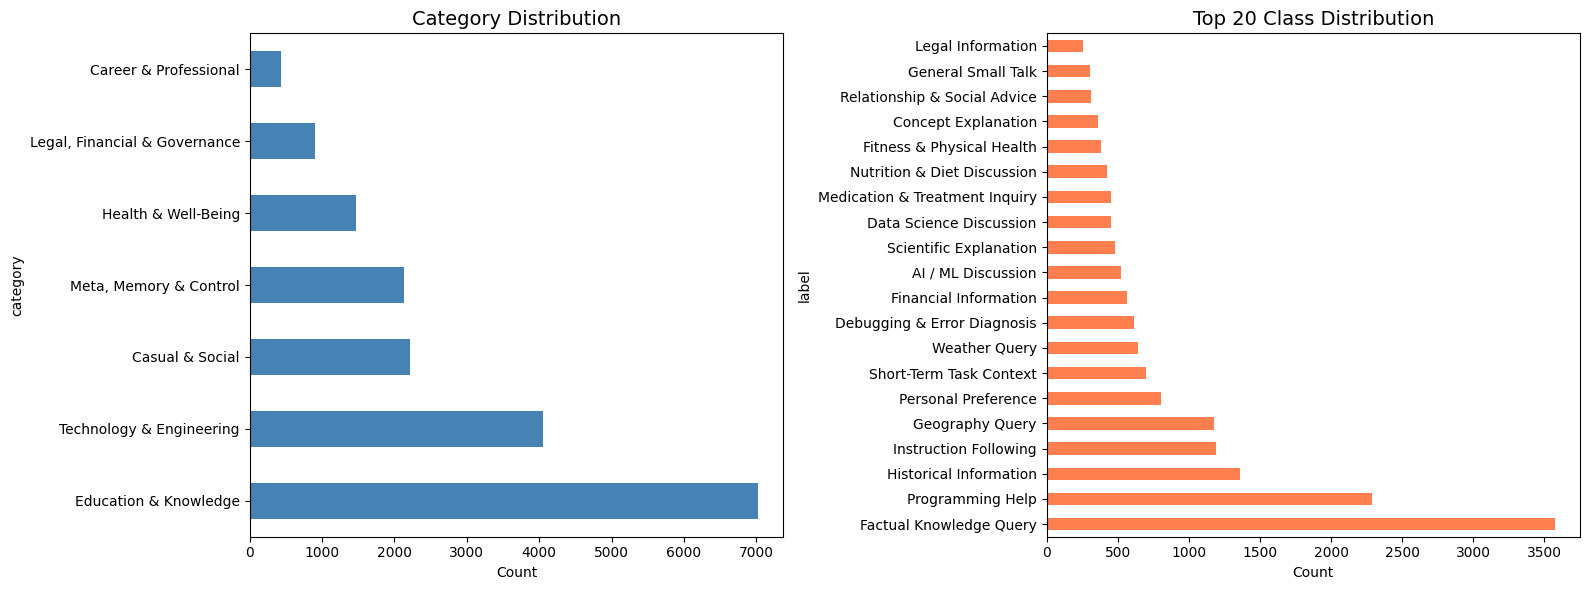

In [21]:
#===============================================================================
# CELL 13: Class Distribution Analysis
#===============================================================================

print("\n" + "="*80)
print("FINAL CLASS DISTRIBUTION")
print("="*80)

# Category distribution
print("\nCategory Distribution:")
category_counts = df['category'].value_counts()
for cat, count in category_counts.items():
    pct = count / len(df) * 100
    bar = '=' * int(pct / 2)
    print(f"  {cat:.<45} {count:>6} ({pct:>5.1f}%) {bar}")

# Class distribution
print("\nTop 20 Classes:")
class_counts = df['label'].value_counts().head(20)
for label, count in class_counts.items():
    pct = count / len(df) * 100
    bar = '=' * int(pct / 2)
    print(f"  {label:.<45} {count:>6} ({pct:>5.1f}%) {bar}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

category_counts.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Category Distribution', fontsize=14)
axes[0].set_xlabel('Count')

class_counts.plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Top 20 Class Distribution', fontsize=14)
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.savefig(output_dir / 'class_distribution.png', dpi=300, bbox_inches='tight')
print(f"\n[PASS] Distribution plot saved to {output_dir / 'class_distribution.png'}")
plt.show()

In [22]:
#===============================================================================
# CELL 14: Final Validation & Save
#===============================================================================

print("\n" + "="*80)
print("FINAL VALIDATION & SAVE")
print("="*80)

# Validation checks
checks = {
    "No nulls in labels": df['label'].isna().sum() == 0,
    "No nulls in categories": df['category'].isna().sum() == 0,
    "All labels valid": df['label'].isin(taxonomy.all_classes).all(),
    "All categories valid": df['category'].isin(taxonomy.categories).all(),
    "Minimum dataset size (>10000)": len(df) > 10000,
    "No duplicates": df.duplicated(subset=['prompt']).sum() == 0,
    "Classes covered (>40)": df['label'].nunique() > 40,
}

all_passed = True
for check, passed in checks.items():
    status = "[PASS]" if passed else "[FAIL]"
    print(f"  {status} {check}")
    if not passed:
        all_passed = False

if not all_passed:
    print("\nWARNING: Some validation checks failed!")
else:
    print("\n[PASS] All validation checks passed!")

# Final statistics
print(f"\nFINAL DATASET STATISTICS")
print("="*80)
print(f"  Total samples: {len(df)}")
print(f"  Unique prompts: {df['prompt'].nunique()}")
print(f"  Categories: {df['category'].nunique()}")
print(f"  Classes: {df['label'].nunique()}")
print(f"  Sources: {df['source'].value_counts().to_dict()}")

# Save dataset
parquet_path = output_dir / 'labeled_dataset.parquet'
csv_path = output_dir / 'labeled_dataset.csv'

df.to_parquet(parquet_path, index=False)
df.to_csv(csv_path, index=False)

print(f"\nDataset saved:")
print(f"  Parquet: {parquet_path} ({parquet_path.stat().st_size / 1024 / 1024:.1f} MB)")
print(f"  CSV: {csv_path} ({csv_path.stat().st_size / 1024 / 1024:.1f} MB)")

# Save metadata
metadata = {
    'total_samples': len(df),
    'num_categories': df['category'].nunique(),
    'num_classes': df['label'].nunique(),
    'category_distribution': df['category'].value_counts().to_dict(),
    'class_distribution': df['label'].value_counts().to_dict(),
    'sources': df['source'].value_counts().to_dict(),
    'method_distribution': df['method'].value_counts().to_dict() if 'method' in df.columns else {},
    'created_at': pd.Timestamp.now().isoformat(),
    'config': {k: v for k, v in CONFIG.items() if 'path' not in k}
}

with open(output_dir / 'dataset_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"  Metadata: {output_dir / 'dataset_metadata.json'}")

print("\n" + "="*80)
print("DATASET PROCESSING COMPLETE (HYBRID APPROACH)")
print("="*80)
print(f"\nOutput directory: {output_dir}")
print(f"\nFiles created:")
print(f"  - labeled_dataset.parquet (for training)")
print(f"  - labeled_dataset.csv (for inspection)")
print(f"  - dataset_metadata.json (statistics)")
print(f"  - taxonomy.json (class definitions)")
print(f"  - class_distribution.png (visualization)")
print(f"\nDataset summary:")
print(f"  - Pattern-labeled: ~{len(conv_df_labeled)} samples")
print(f"  - CLINC150 mapped: ~{len(clinc_df)} samples")
print(f"  - Total after cleaning: {len(df)} samples")
print(f"  - Classes covered: {df['label'].nunique()}/50")
print(f"\nNext step: Run Notebook 2 to train the task classifier")


FINAL VALIDATION & SAVE
  [PASS] No nulls in labels
  [PASS] No nulls in categories
  [PASS] All labels valid
  [PASS] All categories valid
  [PASS] Minimum dataset size (>10000)
  [PASS] No duplicates
  [FAIL] Classes covered (>40)


FINAL DATASET STATISTICS
  Total samples: 18229
  Unique prompts: 18229
  Categories: 7
  Classes: 34
  Sources: {'lmsys': 9240, 'wildchat': 5290, 'clinc150': 3699}

Dataset saved:
  Parquet: /content/drive/MyDrive/memctrl_data/labeled_dataset.parquet (3.9 MB)
  CSV: /content/drive/MyDrive/memctrl_data/labeled_dataset.csv (8.8 MB)
  Metadata: /content/drive/MyDrive/memctrl_data/dataset_metadata.json

DATASET PROCESSING COMPLETE (HYBRID APPROACH)

Output directory: /content/drive/MyDrive/memctrl_data

Files created:
  - labeled_dataset.parquet (for training)
  - labeled_dataset.csv (for inspection)
  - dataset_metadata.json (statistics)
  - taxonomy.json (class definitions)
  - class_distribution.png (visualization)

Dataset summary:
  - Pattern-labeled: 